> ## Download data and Schema integration

We will download the TLC Yellow Taxi Trips Record from Dec 2022 to May 2023 for training set.
For the test set, we will randomly choose 30 days between Jan 2024 and March 2024 from the TLC Yellow Taxi Trips Record

Then we will perform schema integration and filter columns' features. Finally save the cleaned training and testing set in the Curated layer

> Import libraries and functions

In [1]:
%run ../scripts/'download fix schema.py'
%run ../scripts/'preprocess.py'
%run ../scripts/'visualisation.py'
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import log
import random
import numpy as np


> Download training and testing dataset

In [7]:
# Download training dataset from Dec 2022 to May 2023
train_date = {'2022':[12], '2023':[1,2,3,4,5]}
download_taxi('train_set', train_date)  # function from download fix schema.py

Begin month 12
Completed month 12
Begin month 01
Completed month 01
Begin month 02
Completed month 02
Begin month 03
Completed month 03
Begin month 04
Completed month 04
Begin month 05
Completed month 05


<div class="alert alert-block alert-info">
    <b>Note: We will download the set from Jan 2024 to March 2024 but later on will randomly choose 30 days from these three months for testing data </b>
</div>

In [4]:
# Download testing dataset from Jan 2024 to March 2024
test_date = {'2024':[1,2,3]}
download_taxi('test_set', test_date)

Begin month 01
Completed month 01
Begin month 02
Completed month 02
Begin month 03
Completed month 03


In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Preprocess")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/08/25 20:56:13 WARN Utils: Your hostname, LAPTOP-LVDQD9N6 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/25 20:56:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 20:56:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/25 20:56:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


> Investigate datasets' schema

In [4]:
# Schema of Dec 2022 set
sdf_dec = spark.read.parquet('../data/landing/train_set/2022-12.parquet')
sdf_dec.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Detected unsuitable data types in Dec 2022 such as VendorID which should be of integer type

In [62]:
# Schema of Feb 2023 set
sdf_feb = spark.read.parquet('../data/landing/train_set/2023-02.parquet')
sdf_feb.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



Detected unsuitable data types and inconsistent schema with Dec 2022 dataset

> Schema integration

In [5]:
# Get the corrected schema by casting suitable data types for the features
sdf_schema = get_schema(sdf_dec)   # function from download fix schema.py
sdf_schema


StructType([StructField('vendorid', IntegerType(), True), StructField('tpep_pickup_datetime', TimestampNTZType(), True), StructField('tpep_dropoff_datetime', TimestampNTZType(), True), StructField('passenger_count', IntegerType(), True), StructField('trip_distance', DoubleType(), True), StructField('ratecodeid', IntegerType(), True), StructField('store_and_fwd_flag', BooleanType(), True), StructField('pulocationid', IntegerType(), True), StructField('dolocationid', IntegerType(), True), StructField('payment_type', IntegerType(), True), StructField('fare_amount', DoubleType(), True), StructField('extra', DoubleType(), True), StructField('mta_tax', DoubleType(), True), StructField('tip_amount', DoubleType(), True), StructField('tolls_amount', DoubleType(), True), StructField('improvement_surcharge', DoubleType(), True), StructField('total_amount', DoubleType(), True), StructField('congestion_surcharge', DoubleType(), True), StructField('airport_fee', DoubleType(), True)])

In [8]:
def schema_integration(set_name, date, schema):
    '''Read dataset in the given name and date, copy the corrected schema 
    and output to the raw layer'''
    
    for year in date.keys():
        for month in date[year]:
            input_path = f'../data/landing/{set_name}/{year}-{str(month).zfill(2)}.parquet'
            output_path = f'../data/raw/{set_name}/{year}-{str(month).zfill(2)}'

            # read the dataset
            sdf = spark.read.parquet(input_path)
            # copy schema and output
            copy_schema(sdf, schema, output_path)   # function from download fix schema.py

Copy the schema for other datasets and output transformed files into the raw layer

In [98]:
# Schema integration for train set
schema_integration('train_set', train_date, sdf_schema)

In [9]:
# Schema integration for test set
schema_integration('test_set', test_date, sdf_schema)

Raw data is ready with consistent schema

In [6]:
# Check all the training datasets
train_sdf = spark.read.schema(sdf_schema).parquet('../data/raw/train_set/*')
train_sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 1                   
 tpep_pickup_datetime  | 2022-12-01 00:37:35 
 tpep_dropoff_datetime | 2022-12-01 00:47:35 
 passenger_count       | 1                   
 trip_distance         | 2.0                 
 ratecodeid            | 1                   
 store_and_fwd_flag    | false               
 pulocationid          | 170                 
 dolocationid          | 237                 
 payment_type          | 1                   
 fare_amount           | 8.5                 
 extra                 | 3.0                 
 mta_tax               | 0.5                 
 tip_amount            | 3.1                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 0.3                 
 total_amount          | 15.4                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



In [7]:
# Check all the testing datasets
test_sdf = spark.read.schema(sdf_schema).parquet('../data/raw/test_set/*')
test_sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 ratecodeid            | 1                   
 store_and_fwd_flag    | false               
 pulocationid          | 186                 
 dolocationid          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



> Filter columns and Preprocess training and testing datasets

The only valid predictor variables for the trip duration are the variables that are known before the trip ends.
This makes all the payment-related features irrelevant

In [10]:
# Select only valid features for the train and test set
selected_features = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "pulocationid", 
                    "dolocationid"]
train_sdf = train_sdf.select(*selected_features)
test_sdf = test_sdf.select(*selected_features)

> Check for missing values and Descriptive statistics

In [132]:
# Check training set
check_dataset(train_sdf)    # function from preprocess.py

Missing values:


+--------------------+---------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|
+--------------------+---------------------+-------------+------------+------------+
|                   0|                    0|            0|           0|           0|
+--------------------+---------------------+-------------+------------+------------+



tpep_pickup_datetime:
	Latest: 2023-09-05 18:20:48 
	Earliest: 2001-01-01 00:06:49

tpep_dropoff_datetime:
	Latest: 2023-09-05 18:24:21 
	Earliest: 2001-01-01 00:16:31 

Descriptive statistics
+-------+------------------+------------------+-----------------+
|summary|     trip_distance|      pulocationid|     dolocationid|
+-------+------------------+------------------+-----------------+
|  count|          19585935|          19585935|         19585935|
|   mean| 4.139103050734796|165.69693634743504|164.0078257177919|
| stddev|273.10277973912673| 64.25788829295762|69.93702440236571|
|    min|               0.0|                 1|                1|
|    max|         342344.85|               265|              265|
+-------+------------------+------------------+-----------------+



In [12]:
# Check testing set
check_dataset(test_sdf)

Missing values:


+--------------------+---------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|
+--------------------+---------------------+-------------+------------+------------+
|                   0|                    0|            0|           0|           0|
+--------------------+---------------------+-------------+------------+------------+

tpep_pickup_datetime:
	Latest: 2024-04-01 00:34:55 
	Earliest: 2002-12-31 22:17:10

tpep_dropoff_datetime:
	Latest: 2024-04-02 18:08:46 
	Earliest: 2002-12-31 22:42:24 

Descriptive statistics


+-------+----------------+-----------------+------------------+
|summary|   trip_distance|     pulocationid|      dolocationid|
+-------+----------------+-----------------+------------------+
|  count|         9554778|          9554778|           9554778|
|   mean| 4.0422861452141|165.2032947285641|164.18751351418106|
| stddev|265.478273577837|64.05330206884229| 69.40855342677489|
|    min|             0.0|                1|                 1|
|    max|        312722.3|              265|               265|
+-------+----------------+-----------------+------------------+



- No missing values found in the selected columns of training and testing sets
- Ranges of pickup and dropoff time are invalid (earliest being year 2001 and 2002)
- Unreasonable trip distance range
- Some pickup and dropoff locations are not well defined (id = 265)

> Filter invalid and unreasonable values

In [11]:
# Filter pickup and dropoff time, trip distance, pickup and dropoff location
# for training set
train_sdf = filter_columns('train', train_sdf)  # function from preprocess.py

In [18]:
# Check the training set after filtering
check_dataset(train_sdf)

Missing values:


+--------------------+---------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|
+--------------------+---------------------+-------------+------------+------------+
|                   0|                    0|            0|           0|           0|
+--------------------+---------------------+-------------+------------+------------+



tpep_pickup_datetime:
	Latest: 2023-05-31 23:53:47 
	Earliest: 2022-12-01 00:00:00



tpep_dropoff_datetime:
	Latest: 2023-05-31 23:59:56 
	Earliest: 2022-12-01 00:03:42 

Descriptive statistics


+-------+-----------------+------------------+------------------+
|summary|    trip_distance|      pulocationid|      dolocationid|
+-------+-----------------+------------------+------------------+
|  count|         15068351|          15068351|          15068351|
|   mean|4.148748528617814|162.88621429113246|160.56771952020497|
| stddev|4.593031877272062| 63.41974946304086| 70.46096979435906|
|    min|              1.0|                 1|                 1|
|    max|             50.0|               263|               263|
+-------+-----------------+------------------+------------------+



In [50]:
# Filter testing set
test_sdf = filter_columns('test', test_sdf)

In [17]:
# Check the testing set after filtering
check_dataset(test_sdf)

Missing values:


+--------------------+---------------------+-------------+------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|
+--------------------+---------------------+-------------+------------+------------+
|                   0|                    0|            0|           0|           0|
+--------------------+---------------------+-------------+------------+------------+



tpep_pickup_datetime:
	Latest: 2024-03-31 23:54:12 
	Earliest: 2024-01-01 00:00:02



tpep_dropoff_datetime:
	Latest: 2024-03-31 23:59:59 
	Earliest: 2024-01-01 00:04:36 

Descriptive statistics


+-------+------------------+-----------------+-----------------+
|summary|     trip_distance|     pulocationid|     dolocationid|
+-------+------------------+-----------------+-----------------+
|  count|           7152387|          7152387|          7152387|
|   mean|3.9897780111698253|163.0676472064501|161.2206751396422|
| stddev| 4.439953417112491|63.65933727442688| 70.1999432929338|
|    min|               1.0|                1|                1|
|    max|             49.88|              263|              263|
+-------+------------------+-----------------+-----------------+



After filtering out unreasonable values of each feature, both the training and testing datasets contain features in the range of interest

> Compute trip duration

In [12]:
# Trip duration is calculated by taking the unix time of the dropoff time 
# minus the unix time of the pickup time

train_sdf = train_sdf.withColumn(
    "trip_duration",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60  
                                                                            # Convert to minutes
)

# Check descriptive statistics of trip duration
train_sdf.select('trip_duration').describe()

summary,trip_duration
count,15068351
mean,19.689454410107945
stddev,44.20236868647605
min,-76.46666666666667
max,7053.616666666667


In [13]:
# Trip duration for testing set
test_sdf = test_sdf.withColumn(
    "trip_duration",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60  
                                                                            # Convert to minutes
)

# Check descriptive statistics of trip duration
test_sdf.select('trip_duration').describe()

summary,trip_duration
count,9554778
mean,16.126599182455077
stddev,34.33336219348807
min,-52.06666666666667
max,9455.4


The minimum trip duration is negative and maximum trip lasts for a few days 
which is invalid and needs filtering

In [14]:
# We're interest in trips that last at least 5 minutes and at most 2 hours
train_sdf = train_sdf.filter(
    F.col("trip_duration").between(5, 120)
)

# Check descriptive statistics after filtering
train_sdf.select('trip_duration').describe()

summary,trip_duration
count,14766750
mean,18.61647079869783
stddev,12.535506632638388
min,5.0
max,120.0


In [15]:
# Filter trip duration for testing set
test_sdf = test_sdf.filter(
    F.col("trip_duration").between(5, 120)
)

# Check descriptive statistics after filtering
test_sdf.select('trip_duration').describe()

summary,trip_duration
count,8408251
mean,16.96881273327025
stddev,12.108975701628689
min,5.0
max,120.0


The trip durations in training and testing sets are now within the range of interest

> Compute the average speed

For data visualisation purpose, the average speed of each taxi trip is calculated to examine the ratio of trip duration to trip distance. From that we can decide to remove any strange outliers where the trip takes too short or too long

In [16]:
# Taking the total distance travel divided by the total time taken 
# to get the average speed of the trip 

train_sdf = train_sdf.withColumn(
    "speed",    # unit of speed is miles per hour
    F.col("trip_distance") / (F.col("trip_duration") / 60)  # Convert time to hours
)

# Check descriptive statistics of speed
train_sdf.select('speed').describe()

summary,speed
count,14766750
mean,12.382750562517973
stddev,6.823637710095186
min,0.5102763997165132
max,335.13157894736844


In [17]:
# Speed for testing set
test_sdf = test_sdf.withColumn(
    "speed",    # unit of speed is miles per hour
    F.col("trip_distance") / (F.col("trip_duration") / 60)  # Convert time to hours
)

# Check descriptive statistics of speed
test_sdf.select('speed').describe()

summary,speed
count,8408251
mean,14.52519437162144
stddev,1271.7922445797697
min,0.0
max,1906956.7714285715


The minimum speed is 0.5 mph and maximum speed is 380 mph which are both unreasonable and impossible

The speed should be at most 65 mph which is the top speed limit of NYC

In [18]:
# Filter speed in training set to be at most 65 mph
train_sdf = train_sdf.filter(
    F.col("speed") < 65)

# Check descriptive statistics after filtering
train_sdf.select('speed').describe()

summary,speed
count,14766455
mean,12.380965966168404
stddev,6.809368825368269
min,0.5102763997165132
max,64.97560975609757


In [19]:
# Filter speed in testing set
test_sdf = test_sdf.filter(
    F.col("speed") < 65)

# Check descriptive statistics after filtering
test_sdf.select('speed').describe()

summary,speed
count,8407957
mean,11.137784902349596
stddev,6.751035864563021
min,0.0
max,64.99236641221376


> Visualisation of speed and trip duration

For sample of 5% of the data, we will visualise the distribution of speed, which helps to decide to remove outliers. Then we will visualise the distribution of trip duration after outliers are removed.

In [60]:
# Sample 5% of training data
sampled_df = train_sdf.sample(withReplacement=False, fraction=0.05, seed=42)
# Convert this sampled dataframe to Pandas DataFrame
sampled_df = sampled_df.select(*['trip_duration', 'speed']).toPandas()

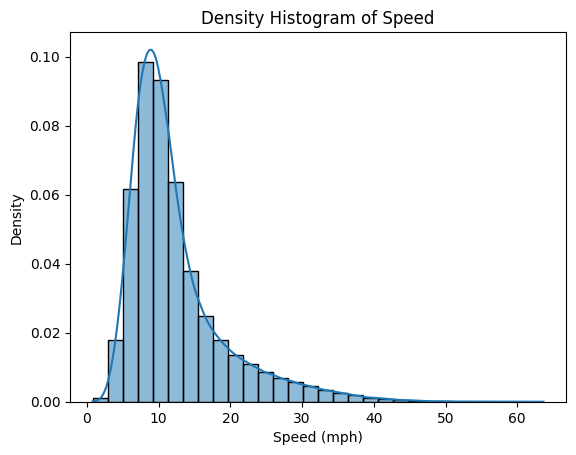

In [35]:
get_histogram(sampled_df, 'speed', 'Speed (mph)', 'Density Histogram of Speed')    # function from visualisation.py

This plot is saved under ../plots/histogram_speed.png

We can see a long right tail in speed, which could be removed as outliers

> Check for outliers

The values of trip distance and trip duration have already been filtered to be within a reasonable range for the interest of this project.

These fixed ranges also ensure consistency in both training and testing dataset so that we do not extrapolate and use out-of-range values of predictor variables (such as trip distance) to predict trip duration 

However we will check the outliers for the ratio of trip distance and trip duration by looking at the outliers for speed

Method: Flag outliers using the IQR rule for N > 100 and decide if the lower and upper bounds are reasonable to remove them

Flag if: $(\sqrt{log{N}} - 0.5) \times IQR$ away from IQR

In [20]:
# Check the upper bound, lower bound and flagged outliers for speed in training set
# sorted by descending order
train_lower, train_upper = check_outliers(train_sdf, 'speed')

+--------------------+---------------------+-------------+------------+------------+------------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|     trip_duration|            speed|
+--------------------+---------------------+-------------+------------+------------+------------------+-----------------+
| 2023-05-28 12:13:36|  2023-05-28 12:20:26|          7.4|         145|         145| 6.833333333333333|64.97560975609757|
| 2023-05-08 07:16:54|  2023-05-08 07:31:21|        15.64|         132|         145|             14.45|64.94117647058825|
| 2023-03-12 16:12:05|  2023-03-12 16:18:58|         7.45|         125|         144| 6.883333333333334|64.93946731234867|
| 2023-04-19 07:21:10|  2023-04-19 07:37:59|         18.2|         132|         234|16.816666666666666|64.93557978196233|
| 2022-12-29 23:50:34|  2022-12-30 00:05:18|        15.92|          93|         145|14.733333333333333|64.83257918552036|
| 2022-12-23 02:59:57|  

In [16]:
print("Lower bound of speed in training set:", train_lower)
print("Upper bound of speed in training set:", train_upper)

Lower bound of speed in training set: -14.957334239499877
Upper bound of speed in training set: 37.34093535034329


In [21]:
# Check outliers for speed in testing set
test_lower, test_upper = check_outliers(test_sdf, 'speed')

+--------------------+---------------------+-------------+------------+------------+------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|     trip_duration|             speed|
+--------------------+---------------------+-------------+------------+------------+------------------+------------------+
| 2024-02-23 23:50:08|  2024-02-23 23:58:52|         9.46|           9|         145| 8.733333333333333| 64.99236641221376|
| 2024-01-29 23:33:12|  2024-01-29 23:43:13|        10.85|          19|         226|10.016666666666667| 64.99168053244591|
| 2024-02-07 22:40:25|  2024-02-07 22:46:54|         7.02|         265|         265| 6.483333333333333| 64.96658097686375|
| 2024-02-07 22:40:25|  2024-02-07 22:46:54|         7.02|         265|         265| 6.483333333333333| 64.96658097686375|
| 2024-01-02 02:05:04|  2024-01-02 02:14:38|        10.35|         132|         166| 9.566666666666666| 64.91289198606272|
| 2024-03-21 13:

In [20]:
print("Lower bound of speed in testing set:", test_lower)
print("Upper bound of speed in testing set:", test_upper)

Lower bound of speed in testing set: -13.444034725258222
Upper bound of speed in testing set: 35.050408827995


The upper bound for speed is around 37 mph, which corresponds to the start of the long tail in the histogram above. Therefore we think it is reasonable to remove these as outliers

However, the lower bound is not useful as it is negative, therefore we will look at speeds that are smaller than the 5th percentile in the speed column and decide if it is reasonable to remove them

In [81]:
# Find the speeds smaller than the 2th percentile in the training set
low_speed = find_low_speed(train_sdf)
print("Lower bound:", low_speed)

+--------------------+---------------------+-------------+------------+------------+------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|pulocationid|dolocationid|     trip_duration|             speed|
+--------------------+---------------------+-------------+------------+------------+------------------+------------------+
| 2022-12-01 14:18:21|  2022-12-01 14:37:14|         1.07|         186|         161|18.883333333333333|3.3998234774933804|
| 2022-12-01 14:31:47|  2022-12-01 14:55:01|          1.4|         186|         107|23.233333333333334|3.6154949784791963|
| 2022-12-01 03:12:15|  2022-12-01 03:32:40|          1.4|          68|         230|20.416666666666668| 4.114285714285714|
| 2022-12-01 05:01:47|  2022-12-01 05:34:17|         1.69|         230|         234|              32.5|              3.12|
| 2022-12-01 05:29:38|  2022-12-01 05:48:56|          1.2|         163|          48|              19.3|3.7305699481865284|
| 2022-12-01 05:

We can see that most of the low speeds occur in the rush hours (eg. from 6am - 8am) which is reasonable

However for speeds < 3 mph, it starts to be unreasonable taken into account extreme traffic conditions in the rush hours of NYC. For instance, it took nearly 1 hour for a trip distance of 2.2 miles.

Therefore, we would still keep instances where speed > 3 mph because we would like to capture the data in rush hours. However we will discard instances where speed < 3 mph

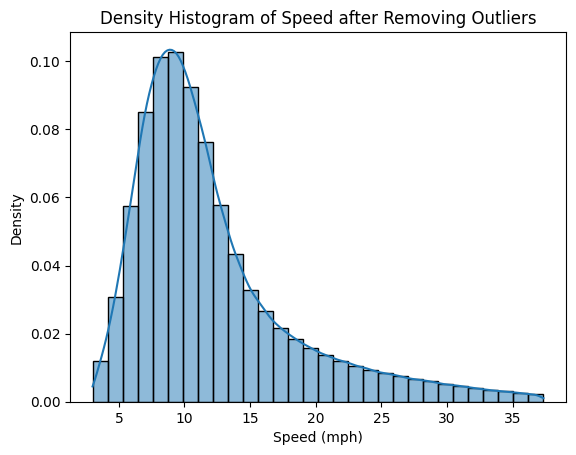

In [38]:
# Visualise speed after removing outliers
filtered_sample = sampled_df[(sampled_df['speed'] >= 3) & (sampled_df['speed'] <= train_upper)]
get_histogram(filtered_sample, 'speed', 'Speed (mph)', 'Density Histogram of Speed after Removing Outliers')

This plot is saved under ../plots/histogram_speed_after.png

> Visualise the distribution of trip duration

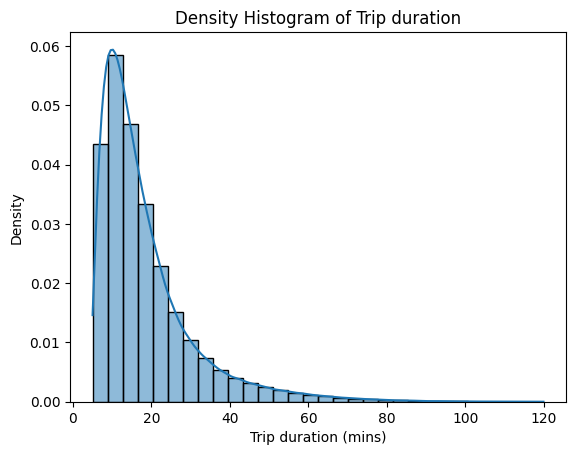

In [39]:
get_histogram(filtered_sample, 'trip_duration', 'Trip duration (mins)', 'Density Histogram of Trip duration')

This plot is saved under ../plots/histogram_trip_duration.png

We can see that distribution of trip duration is very right skewed. Therefore we can apply a log transformation on trip duration to normalize the distribution of this.

/tmp/ipykernel_664251/3790700565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sample['log_trip_duration'] = np.log(filtered_sample['trip_duration'])


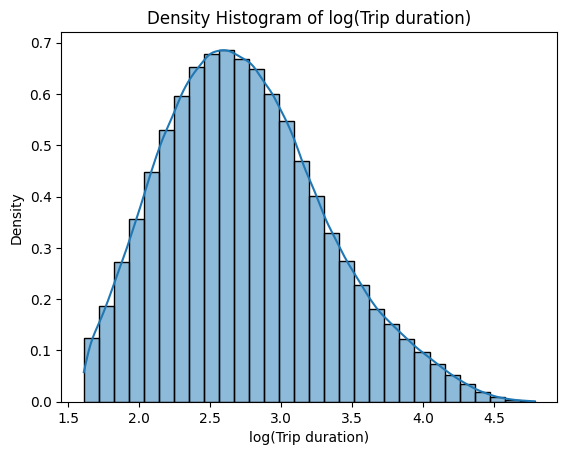

In [45]:
# Apply log transformation on trip duration for visualisation
filtered_sample['log_trip_duration'] = np.log(filtered_sample['trip_duration'])
get_histogram(filtered_sample, 'log_trip_duration', 'log(Trip duration)', 'Density Histogram of log(Trip duration)')

This plot is saved under ../plots/histogram_logtripduration.png

We can see that after applying log transformation, the distribution of trip duration follows the normal distribution better.

> Remove speed outliers and apply log transformation on trip duration on the whole dataset

In [22]:
# Filter training and testing set to remove outliers
train_sdf = train_sdf.filter(F.col('speed').between(3, train_upper))
test_sdf = test_sdf.filter(F.col('speed').between(3, test_upper))

In [24]:
print("Number of remaining instances in train set", train_sdf.count())
print("Number of remaining instances in test set", test_sdf.count())

Number of remaining instances in train set 14593487


Number of remaining instances in test set 8057911


In [64]:
# Apply log transformation on trip duration in training and testing set
train_sdf = train_sdf.withColumn("log_trip_duration", log("trip_duration"))
test_sdf = test_sdf.withColumn("log_trip_duration", log("trip_duration"))

> Flag weekend

We flag a day as weekend if it is a Saturday or Sunday

In [65]:
# Flag weekend for train set
train_sdf = flag_weekend(train_sdf)     #function from preprocess.py

In [66]:
# Flag weekend for test set
test_sdf = flag_weekend(test_sdf)   #function from preprocess.py

> Flag public holidays

A list of public holidays from Dec 2022 to May 2023 and from Jan 2024 to March 2024 is obtained from nyc.gov website as pdf files:

[2022 list of holidays](https://www.nyc.gov/assets/opa/downloads/pdf/2022-list-of-holidays.pdf)

[2023 list of holidays](https://www.nyc.gov/assets/opa/downloads/pdf/2023-list-of-holidays.pdf)

[2024 list of holidays](https://www.nyc.gov/assets/opa/downloads/pdf/2024-list-of-holidays.pdf)

We will categorize public holidays into 4 scales indicating how much it will affect people's lives, with 4 indicating highest effect.

For non-holidays, the scale is set to 0.

Main public holiday (e.g New Year's Day): 4

Observed main public holiday (The day before or next to the main holiday, indicated in the pdf files): 3

Floating holiday (Only for eligible employees): 2

Observed floating holiday: 1

In [67]:
# Public holidays from Dec 2022 to May 2023 for training set
train_holidays = {
    '2022-12-25': 4,  # Christmas Day
    '2022-12-26': 3,  # Christmas Day (observed)
    '2023-01-01': 4,  # New Year's Day
    '2023-01-02': 3,  # New Year's Day (observed)
    '2023-01-16': 4,  # Martin Luther King Jr. Day
    '2023-02-12': 2,  # Lincoln's Birthday (floating holiday)
    '2023-02-13': 1,  # Lincoln's Birthday (observed)
    '2023-02-20': 4,  # Presidents' Day
    '2023-05-29': 4,  # Memorial Day
}

# Convert the dictionary of holidays to a broadcast variable for efficient lookup
train_broadcast = spark.sparkContext.broadcast(train_holidays)

In [68]:
# Public holidays from Jan 2024 to March 2024 for testing set
test_holidays = {
    '2024-01-01': 4,  # New Year's Day
    '2024-01-02': 3,  # New Year's Day (observed)
    '2024-01-15': 4,  # Martin Luther King Jr. Day
    '2024-02-12': 2,  # Lincoln's Birthday (floating holiday)
    '2024-02-13': 1,  # Lincoln's Birthday (observed)
    '2024-02-19': 4,  # Presidents' Day
}

# Convert the dictionary of holidays to a broadcast variable for efficient lookup
test_broadcast = spark.sparkContext.broadcast(test_holidays)

In [69]:
# Flag public holidays and scale in training and testing dataset
train_sdf = flag_holiday(train_sdf, train_broadcast)     # function from preprocess.py
test_sdf = flag_holiday(test_sdf, test_broadcast)     # function from preprocess.py

In [70]:
# Show the final datasets
train_sdf.limit(5)

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,trip_duration,speed,log_trip_duration,is_weekend,is_holiday,holiday_scale
2022-12-01 00:37:35,2022-12-01 00:47:35,2.0,170,237,10.0,12.0,2.302585092994046,false,false,0
2022-12-01 00:34:35,2022-12-01 00:55:21,8.4,138,141,20.766666666666666,24.269662921348317,3.0333491371252976,false,false,0
2022-12-01 00:45:51,2022-12-01 00:53:16,3.0,141,79,7.416666666666667,24.269662921348313,2.0037297199441397,false,false,0
2022-12-01 00:25:25,2022-12-01 00:35:38,2.6,237,164,10.216666666666667,15.269168026101143,2.3240203737141107,false,false,0
2022-12-01 00:20:12,2022-12-01 00:28:49,2.09,79,186,8.616666666666667,14.553191489361701,2.1536983122863287,false,false,0


In [71]:
test_sdf.limit(5)

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,trip_duration,speed,log_trip_duration,is_weekend,is_holiday,holiday_scale
2024-01-01 00:57:55,2024-01-01 01:17:43,1.72,186,79,19.8,5.212121212121212,2.9856819377004897,false,true,4
2024-01-01 00:03:00,2024-01-01 00:09:36,1.8,140,236,6.6,16.363636363636363,1.8870696490323797,false,true,4
2024-01-01 00:17:06,2024-01-01 00:35:01,4.7,236,79,17.916666666666668,15.739534883720932,2.8857313783396625,false,true,4
2024-01-01 00:36:38,2024-01-01 00:44:56,1.4,79,211,8.3,10.120481927710843,2.1162555148025524,false,true,4
2024-01-01 00:54:08,2024-01-01 01:26:31,4.7,148,141,32.38333333333333,8.708183221821926,3.4776438871553395,false,true,4


> Save cleaned datasets

Save the cleaned and filtered training and testing datasets into the Curated layer

In [72]:
# Save training set
train_sdf \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('../data/curated/cleaned_train.parquet')

Randomly choose 30 days for testing data and save to Curated layer

In [73]:
# Extract the date for each instance
test_sdf = test_sdf.withColumn('date', F.to_date(F.col('tpep_pickup_datetime')))

# Get a list of unique dates
unique_dates = test_sdf.select('date').distinct().collect()

# Randomly select 30 unique dates
random_dates = random.sample([row['date'] for row in unique_dates], 30)

# Filter the DataFrame to include only rows with the selected dates
filtered_df = test_sdf.filter(F.col('date').isin(random_dates))

In [74]:
print("Randomly Selected 30 Days:")
for date in random_dates:
    print(date)

Randomly Selected 30 Days:
2024-02-26
2024-02-04
2024-03-24
2024-02-27
2024-02-07
2024-02-09
2024-03-01
2024-01-18
2024-02-01
2024-03-29
2024-02-08
2024-01-14
2024-02-25
2024-01-21
2024-03-18
2024-03-04
2024-02-18
2024-01-03
2024-02-16
2024-02-02
2024-02-14
2024-03-19
2024-01-06
2024-02-03
2024-03-13
2024-01-07
2024-01-23
2024-01-31
2024-01-01
2024-03-30


In [75]:
# Save the randomly chosen testing set
filtered_df \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('../data/curated/cleaned_test.parquet')